# Breast Cancer Diagnostic Dataset

SYDE 572 Final Project

Matthew Keller:  
Leo Lau: 20933924

For this project, we are investigating the [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) dataset. The features in this dataset are computed from the characteristics of the cell nuclei of a fine needle aspirate of a breast mass. There are 30 features within the dataset along with ID numbers of the specific samples and the Diagnosis of the breast mass.


## Preprocessing

Firstly, we want to make sure the dataset is complete. We will inspect the dataset to see if it has the number of features it claims to have and is not missing any data. We also want to check if there is any categorical data that we will need to convert.

In [49]:
import pandas as pd
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import umap
from sklearn.manifold import Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import psutil
import os

In [50]:
USE_KAGGLE = True
  
if USE_KAGGLE:
    import kagglehub

    path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
    df = pd.read_csv(os.path.join(path, "data.csv"))
    df = df.drop(columns=["Unnamed: 32"], axis=1)
    X = df.drop(columns=["id", "diagnosis"])
    y = df[["diagnosis"]]
    y["Diagnosis"] = y["diagnosis"]

else:
    lung_cancer = fetch_ucirepo(id=17) 
    X = lung_cancer.data.features 
    y = lung_cancer.data.targets 
    print(lung_cancer.metadata) 
    print(lung_cancer.variables) 


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/4195254646.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Diagnosis"] = y["diagnosis"]


In [51]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.117635,19.185033,91.882242,654.377582,0.095744,0.103619,0.088898,0.048280,0.181099,0.062757,...,16.235103,25.535692,107.103121,876.987033,0.131532,0.252742,0.274595,0.114182,0.290502,0.083868
std,3.535815,4.266005,24.322027,354.943187,0.013923,0.052470,0.079468,0.038060,0.027487,0.007210,...,4.811267,6.065108,33.374664,567.672841,0.023083,0.155014,0.209398,0.065326,0.063151,0.017848
min,7.691000,9.710000,47.920000,170.400000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,...,8.678000,12.020000,54.490000,223.600000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.705000,16.170000,75.100000,420.300000,0.085825,0.062890,0.029320,0.020340,0.161850,0.057645,...,13.055000,21.045000,84.255000,516.450000,0.114400,0.144950,0.116550,0.063930,0.249500,0.071050
50%,13.300000,18.680000,85.980000,551.700000,0.094620,0.090970,0.061540,0.033410,0.179200,0.061480,...,14.970000,25.220000,97.670000,686.600000,0.130900,0.210100,0.226400,0.098610,0.282700,0.080060
75%,15.740000,21.585000,103.750000,767.600000,0.104550,0.131300,0.132350,0.073895,0.195800,0.066100,...,18.410000,29.690000,124.650000,1031.500000,0.146050,0.341600,0.387200,0.161100,0.317750,0.092070
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.218400,0.937900,1.252000,0.291000,0.663800,0.173000


In [52]:
X_train.isna().sum().sum()

np.int64(0)

In [66]:
X_train.shape

(455, 30)

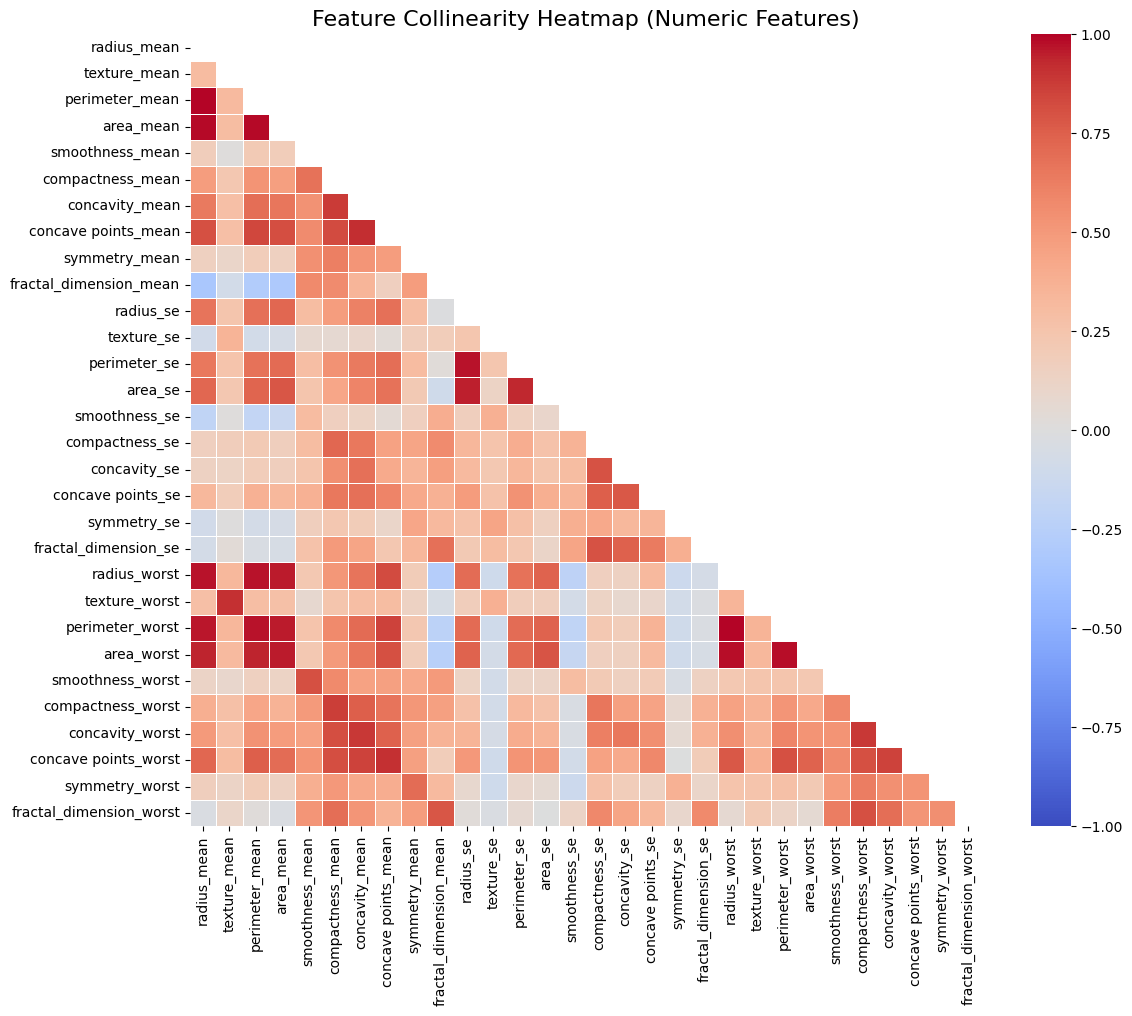


--- Top 3 Correlated Pairs ---
perimeter_mean vs radius_mean: Correlation = 0.9979
perimeter_worst vs radius_worst: Correlation = 0.9933
area_mean vs radius_mean: Correlation = 0.9866


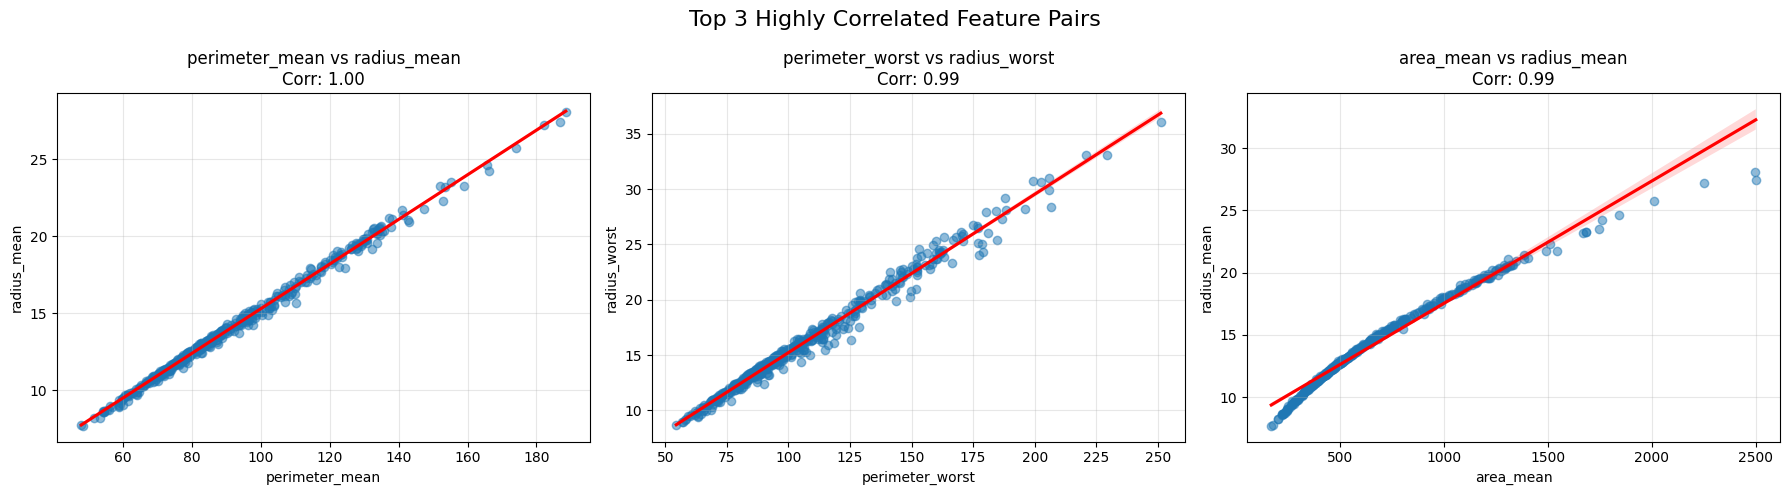

In [70]:
def analyze_correlations(df):
    """
    Analyzes correlations in a dataframe:
    1. Plots a heatmap of all features.
    2. Identifies and plots the top 3 most correlated pairs.
    """
    
    # 1. Filter for numeric columns only
    # Correlations only make sense for numerical data
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty:
        print("No numeric columns found in the dataframe.")
        return

    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()

    # --- PART 1: The Heatmap ---
    plt.figure(figsize=(12, 10))
    # Mask the upper triangle (optional, makes it cleaner)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=False, 
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5)
    
    plt.title('Feature Collinearity Heatmap (Numeric Features)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- PART 2: Find Top 3 Pairs ---
    # We take the absolute value because a strong negative correlation (-0.9) 
    # is just as significant as a strong positive one (0.9).
    
    # Unstack the matrix to get pairs
    corr_pairs = corr_matrix.abs().unstack()
    
    # Sort descending
    sorted_pairs = corr_pairs.sort_values(ascending=False)
    
    # Filter out self-correlations (which equal 1.0)
    sorted_pairs = sorted_pairs[sorted_pairs < 1.0]
    
    # Remove duplicates (e.g., keeping A-B but removing B-A)
    # We do this by iterating and tracking seen pairs
    unique_pairs = []
    seen_cols = set()
    
    for index, value in sorted_pairs.items():
        col1, col2 = index
        
        # Create a frozenset to handle (A, B) same as (B, A)
        pair_set = frozenset([col1, col2])
        
        if pair_set not in seen_cols:
            unique_pairs.append((col1, col2, value, corr_matrix.loc[col1, col2]))
            seen_cols.add(pair_set)
            
        if len(unique_pairs) >= 3:
            break

    print("\n--- Top 3 Correlated Pairs ---")
    for col1, col2, abs_corr, real_corr in unique_pairs:
        print(f"{col1} vs {col2}: Correlation = {real_corr:.4f}")

    # --- PART 3: Compare Top 3 Pairs Visuals ---
    if unique_pairs:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Top 3 Highly Correlated Feature Pairs', fontsize=16)

        for i, (col1, col2, _, real_corr) in enumerate(unique_pairs):
            # Create a scatter plot with a regression line
            sns.regplot(data=df, x=col1, y=col2, ax=axes[i], 
                        scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
            
            axes[i].set_title(f'{col1} vs {col2}\nCorr: {real_corr:.2f}')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough correlations found to plot top 3.")

np.random.seed(42)

analyze_correlations(X_train)

In [67]:
X_test.shape

(114, 30)

This confirms that the dataset is complete with no missing data. There is also no categorical data except for the labels so we will use the dataset as it.

## Principal Component Analysis

In [53]:
# Setting seed
RANDOM_STATE = 42

Lets look at PCA in 2D by taking 2 components


--- Explained Variance ---
Variance explained by PC1: 43.50%
Variance explained by PC2: 19.50%
Total variance explained by 2 components: 63.00%


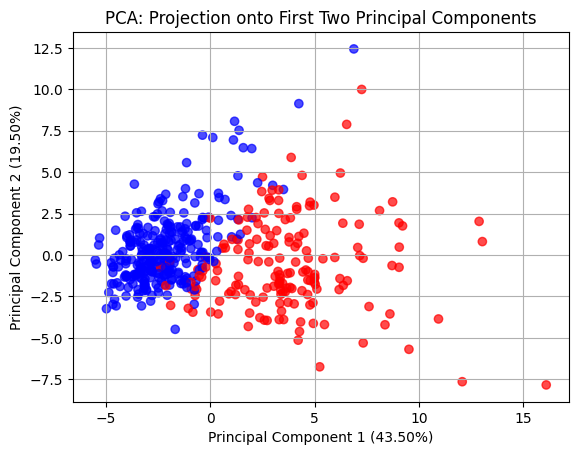

In [54]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_train)


pca = PCA(n_components=2, random_state=RANDOM_STATE)
principal_components = pca.fit_transform(x_scaled)

print("\n--- Explained Variance ---")
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")

scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], 
                      c=["red" if label == "M" else "blue" for label in y_train["Diagnosis"]],
                      alpha=0.7) 

# Add labels and title
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.title("PCA: Projection onto First Two Principal Components")
plt.grid(True)

Lets take a look in 3D


--- Explained Variance (3 Components) ---
Variance explained by PC1: 43.50%
Variance explained by PC2: 19.50%
Variance explained by PC3: 9.78%
Total variance explained by 3 components: 72.78%


/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/3515643145.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(principal_components_3d[:, 0], # PC1 on x-axis


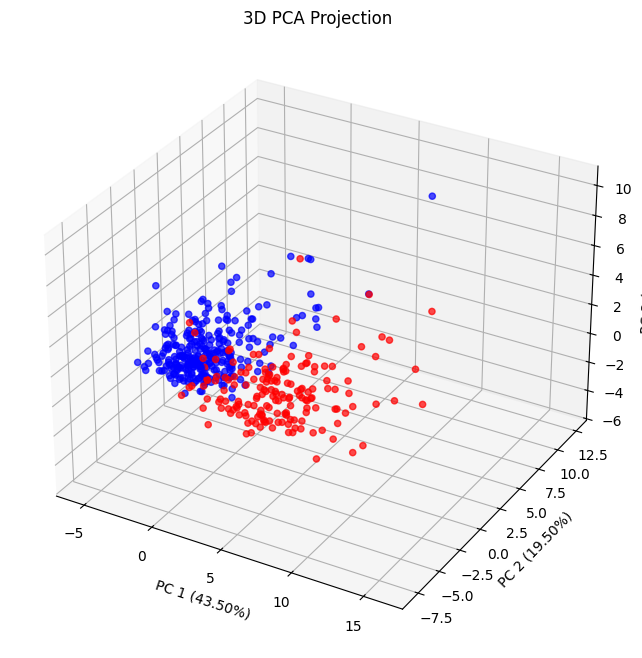

In [55]:
pca = PCA(n_components=3, random_state=RANDOM_STATE)
principal_components_3d = pca.fit_transform(x_scaled)


print("\n--- Explained Variance (3 Components) ---")
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Variance explained by PC3: {pca.explained_variance_ratio_[2]:.2%}") # Added PC3
print(f"Total variance explained by 3 components: {pca.explained_variance_ratio_.sum():.2%}")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(principal_components_3d[:, 0], # PC1 on x-axis
                     principal_components_3d[:, 1], # PC2 on y-axis
                     principal_components_3d[:, 2], # PC3 on z-axis
                     c=["red" if label == "M" else "blue" for label in y_train["Diagnosis"]],
                     cmap='viridis', 
                     alpha=0.7)

ax.set_xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})")
ax.set_ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})")
ax.set_zlabel(f"PC 3 ({pca.explained_variance_ratio_[2]:.2%})")
ax.set_title("3D PCA Projection")

plt.show()

Taking a look at the variance explained by each PC

Number of components needed for 95% variance: 10


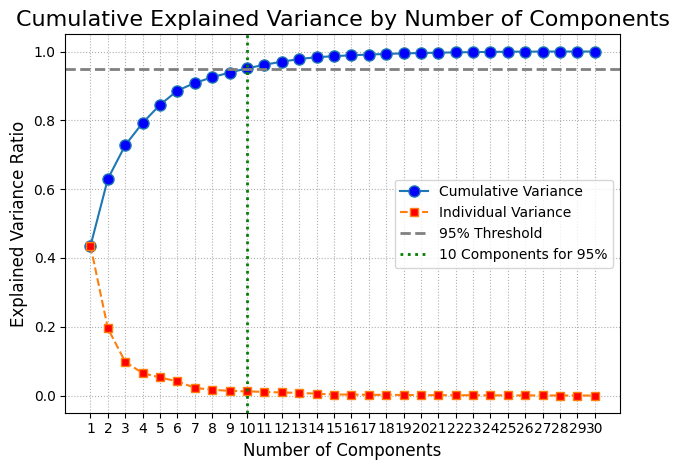

In [56]:
pca = PCA(n_components=None, random_state=RANDOM_STATE)
pca.fit(x_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

components_for_95_variance = np.argmax(cumulative_variance >= 0.95) + 1 # Add 1 for 0-based index

print(f"Number of components needed for 95% variance: {components_for_95_variance}")

num_components = len(explained_variance)
component_numbers = np.arange(1, num_components + 1)

plt.plot(component_numbers, cumulative_variance, 'o-', markerfacecolor='blue', markersize=8, label='Cumulative Variance')
plt.plot(component_numbers, explained_variance, 's--', markerfacecolor='red', markersize=6, label='Individual Variance')

plt.title('Cumulative Explained Variance by Number of Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(component_numbers)

plt.axhline(y=0.95, color='gray', linestyle='--', linewidth=2, label='95% Threshold')

plt.axvline(x=components_for_95_variance, color='green', linestyle=':', linewidth=2, 
            label=f'{components_for_95_variance} Components for 95%')

plt.grid(True, linestyle=':')
plt.legend(loc='center right')
plt.tight_layout()


10 PCA components result in a variance of 95%, but there seems to be a sharper cuttoff at ~18 components

Lets project the target class onto the PC space

/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/2665321470.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(principal_components[:, 0],


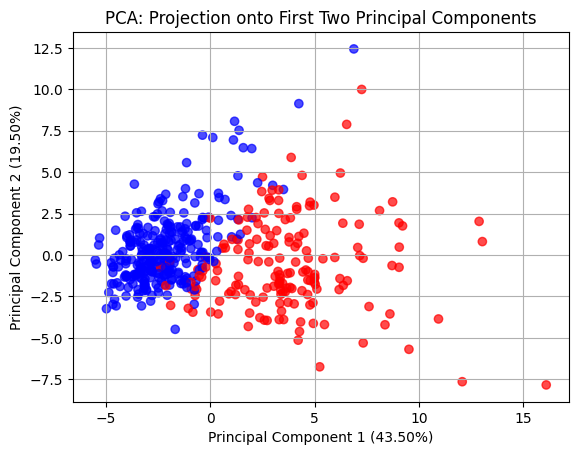

In [57]:
def plot_pca_2d(principal_components, pca_model, y=None):
    """
    Plots the first two principal components.
    
    Args:
        principal_components (np.array): The data transformed by PCA.
        pca_model (PCA): The fitted PCA object (to get variance ratios).
        y (array-like, optional): Labels for coloring the points.
    """
    
    # Get the variance explained by the first two components
    pc1_var = pca_model.explained_variance_ratio_[0]
    pc2_var = pca_model.explained_variance_ratio_[1]
    
    
    scatter = plt.scatter(principal_components[:, 0], 
                          principal_components[:, 1], 
                          c=["red" if label == "M" else "blue" for label in y["Diagnosis"]] if y is not None else None,
                          cmap='viridis', # A common colormap
                          alpha=0.7)
    
    plt.xlabel(f"Principal Component 1 ({pc1_var:.2%})")
    plt.ylabel(f"Principal Component 2 ({pc2_var:.2%})")
    plt.title("PCA: Projection onto First Two Principal Components")
        
    plt.grid(True)
    plt.show()


plot_pca_2d(principal_components, pca, y=y_train)

## TSNE

Lets take a look at using TSNE for dimensionality reduction

/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/893882462.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(tsne_results[:, 0],


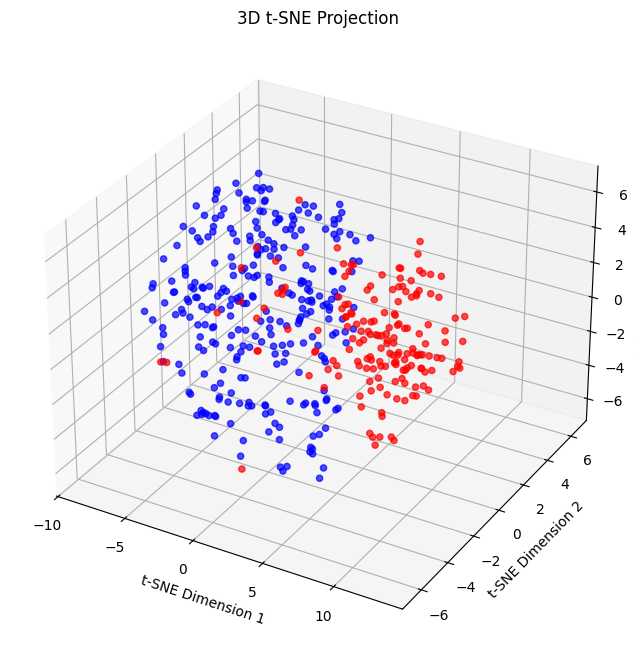

In [58]:
def fit_tsne(tsne_kwargs, x_data):
    tsne = TSNE(**tsne_kwargs)
    tsne_results = tsne.fit_transform(x_data)
    return tsne_results

def plot_components_3d(tsne_results, y=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(tsne_results[:, 0],
                         tsne_results[:, 1],
                         tsne_results[:, 2],        
                         c=["red" if label == "M" else "blue" for label in y["Diagnosis"]] if y is not None else None,
                         cmap='viridis', # A common colormap
                         alpha=0.7)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")
    ax.set_title("3D t-SNE Projection")

tsne_results = fit_tsne({"n_components": 3, "random_state": RANDOM_STATE}, x_scaled)

plot_components_3d(tsne_results, y_train)

/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/58699654.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0],


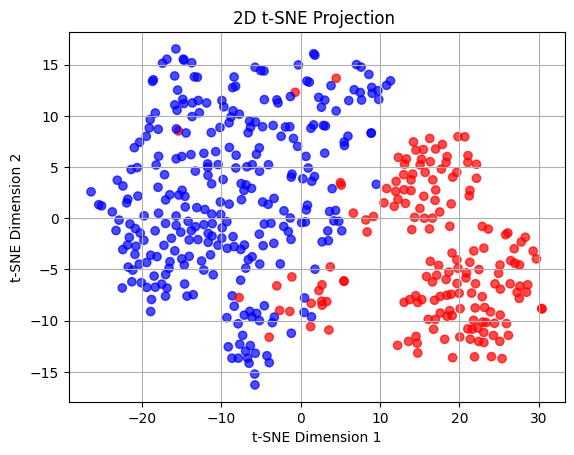

In [59]:
def plot_2d(tsne_results, y=None, additional_title=""):

    scatter = plt.scatter(tsne_results[:, 0],
                         tsne_results[:, 1],
                         c=["red" if label == "M" else "blue" for label in y["Diagnosis"]] if y is not None else None,
                         cmap='viridis', # A common colormap
                         alpha=0.7)
    
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title(f"2D t-SNE Projection {additional_title}")

    
    plt.grid(True)
    plt.show()
   
tsne_2d = fit_tsne({"n_components": 2, "random_state": RANDOM_STATE}, x_scaled)
plot_2d(tsne_2d, y_train)


We can also use TSNE to reduce PCA components

/var/folders/_m/zyrbphls3w34fhsvk8rqt6880000gn/T/ipykernel_77750/58699654.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0],


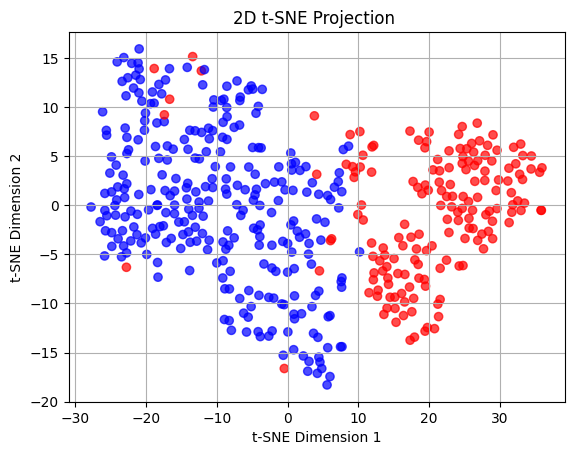

In [ ]:
pca = PCA(n_components=None, random_state=RANDOM_STATE)
x_pca_all_components = pca.fit_transform(x_scaled)

x_pca_10 = x_pca_all_components[:, :10]

tsne_pca_2d = fit_tsne({"n_components": 2, "random_state": RANDOM_STATE}, x_pca_10)
plot_2d(tsne_pca_2d, y_train, additional_title="(After PCA to 10 Components)")

Tuning the perplexity variable in the TSNE function creates different results. The perplexity variable relates to the number of nearest neighbors used in the manifold learning algorithm

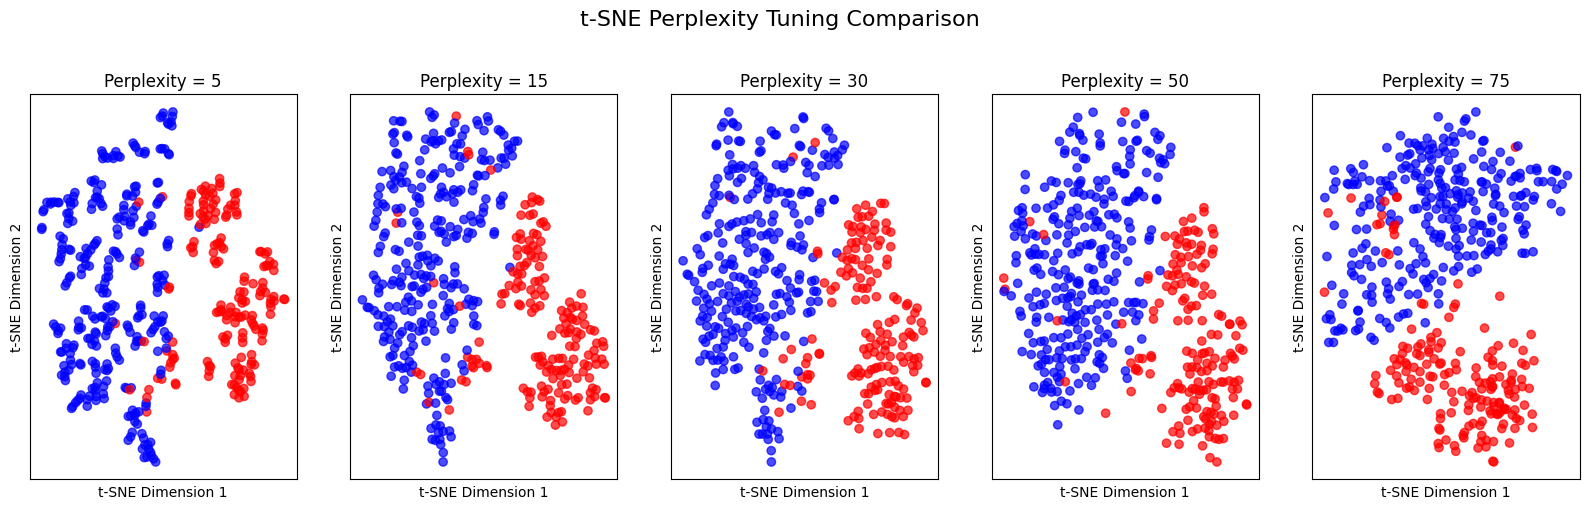

Tuning complete.


In [61]:
perplexity_values = [5, 15, 30, 50, 75]

fig, axes = plt.subplots(1, len(perplexity_values), figsize=(20, 5))


colours = ["red" if label == "M" else "blue" for label in y_train["Diagnosis"]]


def subplot_2d(ax, tsne_results, hyperparam_name, hyperparam_value, model_name, colours=None):
    """Plots 2D t-SNE results on a specific matplotlib axis."""
    ax.scatter(tsne_results[:, 0],
               tsne_results[:, 1],
               c=colours,
               alpha=0.7)

    ax.set_title(f"{hyperparam_name} = {hyperparam_value}")
    ax.set_xlabel(f"{model_name} Dimension 1")
    ax.set_ylabel(f"{model_name} Dimension 2")
    ax.set_xticks([])
    ax.set_yticks([])

for i, perplexity in enumerate(perplexity_values):
    tsne_kwargs = {
        "n_components": 2,
        "random_state": RANDOM_STATE,
        "perplexity": perplexity,
    }
    tsne_results = fit_tsne(tsne_kwargs, x_scaled)
    

    subplot_2d(axes[i], tsne_results, hyperparam_name="Perplexity", hyperparam_value=perplexity, model_name="t-SNE", colours=colours)

    
plt.suptitle("t-SNE Perplexity Tuning Comparison", fontsize=16, y=1.05)
plt.show()

print("Tuning complete.")

## UMAP

Running UMAP for different n_neighbors values...


/Users/matthewkeller/4A/syde-572/final-project/lung-class/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/matthewkeller/4A/syde-572/final-project/lung-class/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewkeller/4A/syde-572/final-project/lung-class/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewkeller/4A/syde-572/final-project/lung-class/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


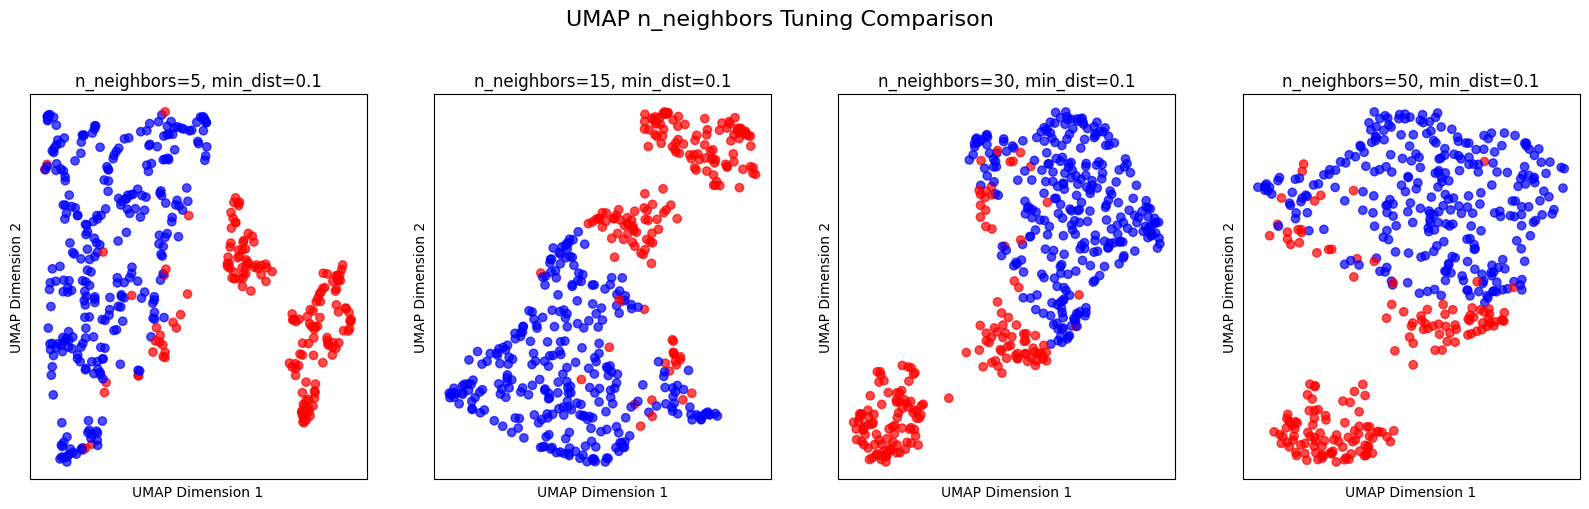

In [62]:
def plot_components_2d_umap(ax, umap_results, y, n_neighbors, min_dist):
    """Plots 2D UMAP results on a specific matplotlib axis."""
    
    colors = ["red" if label == "M" else "blue" for label in y["Diagnosis"]]
    
    ax.scatter(
        umap_results[:, 0],
        umap_results[:, 1],
        c=colors,
        alpha=0.7
    )

    ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.set_xticks([])
    ax.set_yticks([])


# -------------------------------
# Hyperparameter tuning options
# -------------------------------
n_neighbors_list = [5, 15, 30, 50]
min_dist = 0.1 

fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(20, 5))

print("Running UMAP for different n_neighbors values...")

for i, n_neighbors in enumerate(n_neighbors_list):

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=42
    )

    umap_results = reducer.fit_transform(x_scaled)

    plot_components_2d_umap(
        axes[i],
        umap_results,
        y_train,
        n_neighbors=n_neighbors,
        min_dist=min_dist
    )

plt.suptitle("UMAP n_neighbors Tuning Comparison", fontsize=16, y=1.05)
plt.show()


## Isomap

We can similarly tune the parameter to n_neighbors

Running Isomap for different n_neighbors values...


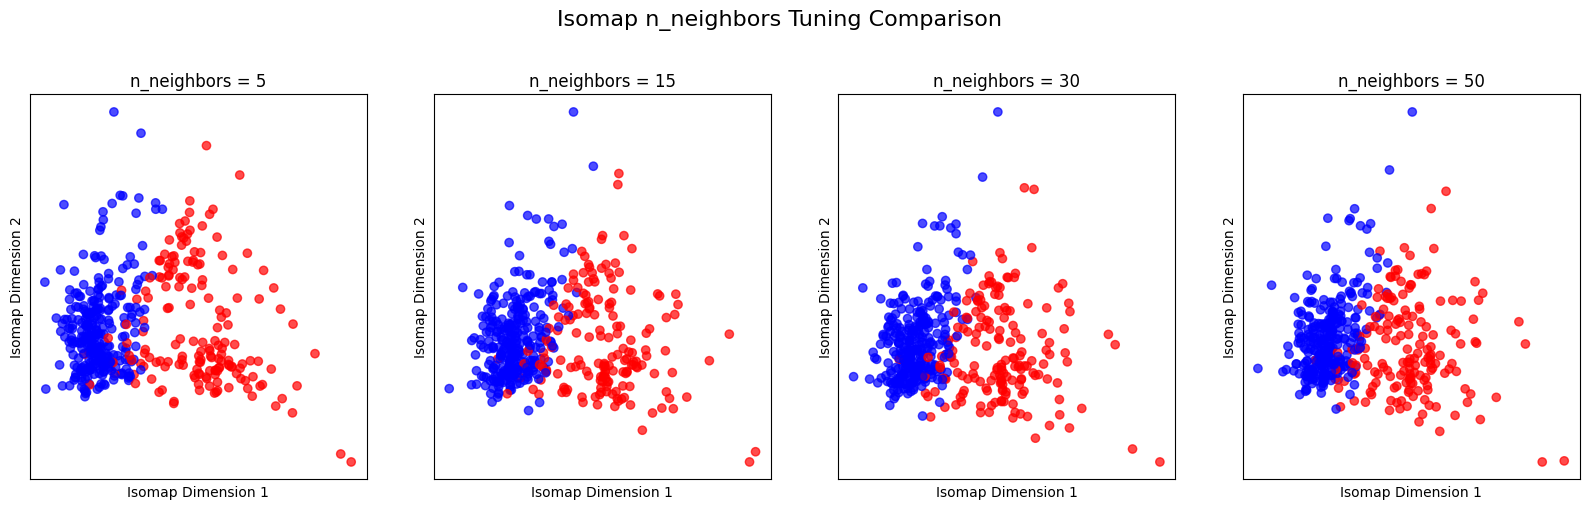

In [63]:
def plot_components_2d_isomap(ax, isomap_results, y, n_neighbors):
    """Plots 2D Isomap results on a specific matplotlib axis."""
    colors = ["red" if label == "M" else "blue" for label in y["Diagnosis"]]
    
    ax.scatter(isomap_results[:, 0],
               isomap_results[:, 1],
               c=colors,
               alpha=0.7)
    
    ax.set_title(f"n_neighbors = {n_neighbors}")
    ax.set_xlabel("Isomap Dimension 1")
    ax.set_ylabel("Isomap Dimension 2")
    ax.set_xticks([])
    ax.set_yticks([])

n_neighbors_list = [5, 15, 30, 50] 

fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(20, 5))

print("Running Isomap for different n_neighbors values...")

for i, n_neighbors in enumerate(n_neighbors_list):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
    
    isomap_results = isomap.fit_transform(x_scaled)

    subplot_2d(axes[i], 
               isomap_results, 
               hyperparam_name="n_neighbors", 
               hyperparam_value=n_neighbors, 
               model_name="Isomap", 
               colours=colours)

plt.suptitle("Isomap n_neighbors Tuning Comparison", fontsize=16, y=1.05)
plt.show()

## Training the classification model

Using PCA components to train the model. Lets see how many PCs produce the best test accuracy

In [64]:
# Function to get current memory usage (in MB)
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # convert bytes → MB
    return mem

In [65]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_acc = 0
best_components = None

accuracies = []

print("Running PCA sweeps...")

for n in range(1, X_train.shape[1] + 1):   # sweep from 1 to full dimensionality

    # Apply PCA
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_train.values.ravel(), test_size=0.2, random_state=42
    )

    # Train classifier
    clf = LogisticRegression(max_iter=1500)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((n, acc))

    print(f"PCA={n:2d} -> Accuracy = {acc:.5f}")

    # Track best
    if acc > best_acc:
        best_acc = acc
        best_components = n


print("\n==========================")
print(f" Best PCA components: {best_components}")
print(f" Best accuracy:       {best_acc:.5f}")
print("==========================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"PCA took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

components = [a[0] for a in accuracies]
scores = [a[1] for a in accuracies]

plt.plot(components, scores, marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs PCA Components")
plt.grid(True)
plt.show()



Running PCA sweeps...


ValueError: Found input variables with inconsistent numbers of samples: [455, 910]

Doing the same thing for TSNE

Running TSNE sweeps...

Testing: n_components=1, perplexity=5 ...
 -> Accuracy = 0.92105
Testing: n_components=1, perplexity=15 ...
 -> Accuracy = 0.92105
Testing: n_components=1, perplexity=30 ...
 -> Accuracy = 0.92982
Testing: n_components=1, perplexity=50 ...
 -> Accuracy = 0.92982
Testing: n_components=1, perplexity=75 ...
 -> Accuracy = 0.93860
Testing: n_components=2, perplexity=5 ...
 -> Accuracy = 0.93860
Testing: n_components=2, perplexity=15 ...
 -> Accuracy = 0.93860
Testing: n_components=2, perplexity=30 ...
 -> Accuracy = 0.94737
Testing: n_components=2, perplexity=50 ...
 -> Accuracy = 0.96491
Testing: n_components=2, perplexity=75 ...
 -> Accuracy = 0.94737
Testing: n_components=3, perplexity=5 ...
 -> Accuracy = 0.93860
Testing: n_components=3, perplexity=15 ...
 -> Accuracy = 0.92982
Testing: n_components=3, perplexity=30 ...
 -> Accuracy = 0.94737
Testing: n_components=3, perplexity=50 ...
 -> Accuracy = 0.96491
Testing: n_components=3, perplexity=75 ...
 -> Accuracy

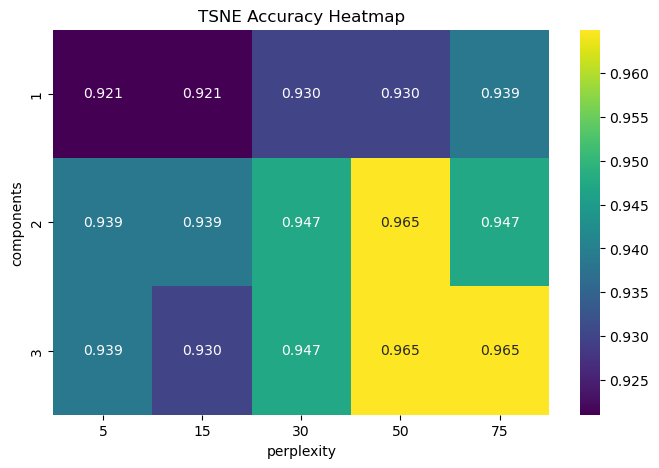

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_acc = 0
best_components = None

accuracies = []
perplexity_values = [5, 15, 30, 50, 75]
print("Running TSNE sweeps...\n")

for n in range(1, 4):  # 1 to 3 components
    for p in perplexity_values:

        print(f"Testing: n_components={n}, perplexity={p} ...")

        tsne = TSNE(
            n_components=n,
            perplexity=p,
            random_state=42
        )

        X_tsne = tsne.fit_transform(X_scaled)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_tsne, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best TSNE parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   perplexity   = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"TSNE took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

df = pd.DataFrame(accuracies, columns=["components", "perplexity", "accuracy"])

pivot = df.pivot(index="components", columns="perplexity", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("TSNE Accuracy Heatmap")
plt.show()

Same thing for UMAP

Running UMAP sweeps...

Testing: n_components=1, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.88596
Testing: n_components=1, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=1, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=1, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=2, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=2, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=2, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=2, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=3, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=3, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=3, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=3, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=4, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=4, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=4, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=4, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=5, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=5, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=5, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=5, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=6, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=6, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=6, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=6, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=7, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=7, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=7, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=7, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=8, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=8, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=8, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=8, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=9, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=9, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=9, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=9, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=10, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=10, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=10, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=10, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491

 Best UMAP parameters:
   n_components = 2
   n_neighbours = 50
 Best accuracy  = 0.96491
UMAP took: Time=24.67s, Memory=2.83MB


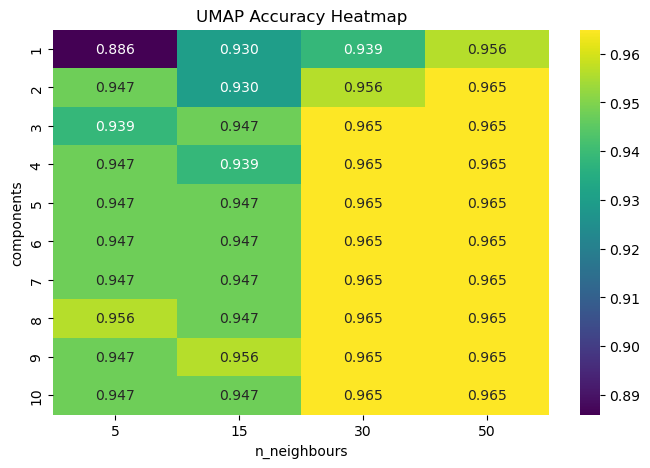

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_acc = 0
best_components = None

accuracies = []
n_neighbours_list = [5, 15, 30, 50]

print("Running UMAP sweeps...\n")

for n in range(1, 11):  
    for p in n_neighbors_list:

        print(f"Testing: n_components={n}, n_neighbours={p} ...")

        umap_reducer = umap.UMAP(
            n_components=n,
            n_neighbors=p, 
            random_state=42)

        X_umap = umap_reducer.fit_transform(X_scaled)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_umap, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best UMAP parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   n_neighbours = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"UMAP took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

df = pd.DataFrame(accuracies, columns=["components", "n_neighbours", "accuracy"])

pivot = df.pivot(index="components", columns="n_neighbours", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("UMAP Accuracy Heatmap")
plt.show()

And Isomap

Running Isomap sweeps...

Testing: n_components=1, n_neighbours=5 ...
 -> Accuracy = 0.94737
Testing: n_components=1, n_neighbours=15 ...
 -> Accuracy = 0.96491
Testing: n_components=1, n_neighbours=30 ...
 -> Accuracy = 0.96491
Testing: n_components=1, n_neighbours=50 ...
 -> Accuracy = 0.97368
Testing: n_components=2, n_neighbours=5 ...
 -> Accuracy = 0.96491
Testing: n_components=2, n_neighbours=15 ...
 -> Accuracy = 0.98246
Testing: n_components=2, n_neighbours=30 ...
 -> Accuracy = 0.97368
Testing: n_components=2, n_neighbours=50 ...
 -> Accuracy = 0.99123
Testing: n_components=3, n_neighbours=5 ...
 -> Accuracy = 0.97368
Testing: n_components=3, n_neighbours=15 ...
 -> Accuracy = 0.97368
Testing: n_components=3, n_neighbours=30 ...
 -> Accuracy = 0.97368
Testing: n_components=3, n_neighbours=50 ...
 -> Accuracy = 0.99123
Testing: n_components=4, n_neighbours=5 ...
 -> Accuracy = 0.95614
Testing: n_components=4, n_neighbours=15 ...
 -> Accuracy = 0.97368
Testing: n_components=4, n

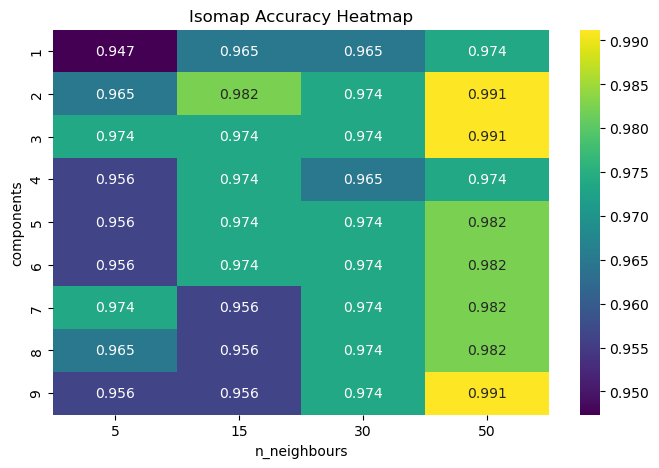

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_acc = 0
best_components = None

accuracies = []
n_neighbours_list = [5, 15, 30, 50]

print("Running Isomap sweeps...\n")

for n in range(1, 10):  
    for p in n_neighbors_list:

        print(f"Testing: n_components={n}, n_neighbours={p} ...")

        isomap = Isomap(
            n_components=n,
            n_neighbors=p)

        X_isomap = isomap.fit_transform(X_scaled)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_isomap, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best Isomap parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   n_neighbours = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"Isomap took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")


df = pd.DataFrame(accuracies, columns=["components", "n_neighbours", "accuracy"])

pivot = df.pivot(index="components", columns="n_neighbours", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Isomap Accuracy Heatmap")
plt.show()

We can also first run PCA then use the non-linear dimensionality techniques. Lets use 10 PCs from PCA.

Running TSNE sweeps...

Testing: n_components=1, perplexity=5 ...
 -> Accuracy = 0.91228
Testing: n_components=1, perplexity=15 ...
 -> Accuracy = 0.92982
Testing: n_components=1, perplexity=30 ...
 -> Accuracy = 0.92982
Testing: n_components=1, perplexity=50 ...
 -> Accuracy = 0.92982
Testing: n_components=1, perplexity=75 ...
 -> Accuracy = 0.92982
Testing: n_components=2, perplexity=5 ...
 -> Accuracy = 0.93860
Testing: n_components=2, perplexity=15 ...
 -> Accuracy = 0.94737
Testing: n_components=2, perplexity=30 ...
 -> Accuracy = 0.95614
Testing: n_components=2, perplexity=50 ...
 -> Accuracy = 0.94737
Testing: n_components=2, perplexity=75 ...
 -> Accuracy = 0.95614
Testing: n_components=3, perplexity=5 ...
 -> Accuracy = 0.94737
Testing: n_components=3, perplexity=15 ...
 -> Accuracy = 0.92982
Testing: n_components=3, perplexity=30 ...
 -> Accuracy = 0.96491
Testing: n_components=3, perplexity=50 ...
 -> Accuracy = 0.96491
Testing: n_components=3, perplexity=75 ...
 -> Accuracy

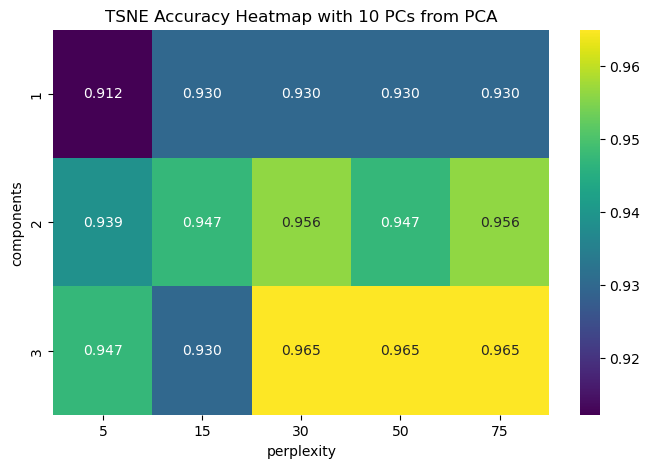

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X_scaled)

best_acc = 0
best_components = None

accuracies = []
perplexity_values = [5, 15, 30, 50, 75]
print("Running TSNE sweeps...\n")

for n in range(1, 4):  # 1 to 3 components
    for p in perplexity_values:

        print(f"Testing: n_components={n}, perplexity={p} ...")

        tsne = TSNE(
            n_components=n,
            perplexity=p,
            random_state=42
        )

        X_tsne = tsne.fit_transform(X_pca)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_tsne, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best TSNE parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   perplexity   = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"TSNE + PCA took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

df = pd.DataFrame(accuracies, columns=["components", "perplexity", "accuracy"])

pivot = df.pivot(index="components", columns="perplexity", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("TSNE Accuracy Heatmap with 10 PCs from PCA")
plt.show()

Same thing with UMAP

Running UMAP sweeps...

Testing: n_components=1, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.89474
Testing: n_components=1, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=1, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.94737
Testing: n_components=1, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=2, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=2, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=2, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=2, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=3, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=3, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=3, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=3, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=4, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=4, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=4, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=4, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=5, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=5, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=5, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=5, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=6, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=6, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=6, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=6, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=7, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=7, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=7, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=7, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=8, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=8, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=8, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=8, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=9, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.92982
Testing: n_components=9, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=9, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=9, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=10, n_neighbours=5 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.93860
Testing: n_components=10, n_neighbours=15 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.95614
Testing: n_components=10, n_neighbours=30 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491
Testing: n_components=10, n_neighbours=50 ...


/opt/homebrew/anaconda3/envs/syde575/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> Accuracy = 0.96491

 Best UMAP parameters:
   n_components = 2
   n_neighbours = 30
 Best accuracy  = 0.96491
UMAP + PCA took: Time=24.78s, Memory=-2.03MB


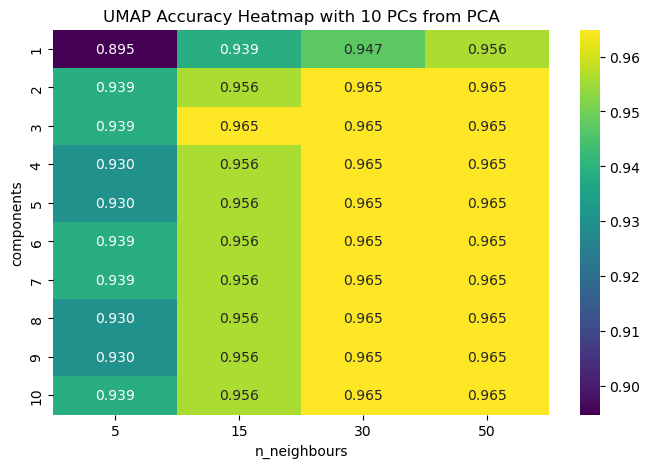

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X_scaled)

best_acc = 0
best_components = None

accuracies = []
n_neighbours_list = [5, 15, 30, 50]

print("Running UMAP sweeps...\n")

for n in range(1, 11):  
    for p in n_neighbors_list:

        print(f"Testing: n_components={n}, n_neighbours={p} ...")

        umap_reducer = umap.UMAP(
            n_components=n,
            n_neighbors=p, 
            random_state=42)

        X_umap = umap_reducer.fit_transform(X_pca)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_umap, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best UMAP parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   n_neighbours = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"UMAP + PCA took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

df = pd.DataFrame(accuracies, columns=["components", "n_neighbours", "accuracy"])

pivot = df.pivot(index="components", columns="n_neighbours", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("UMAP Accuracy Heatmap with 10 PCs from PCA")
plt.show()

And lastly Isomap again

Running Isomap sweeps...

Testing: n_components=1, n_neighbours=5 ...
 -> Accuracy = 0.94737
Testing: n_components=1, n_neighbours=15 ...
 -> Accuracy = 0.96491
Testing: n_components=1, n_neighbours=30 ...
 -> Accuracy = 0.96491
Testing: n_components=1, n_neighbours=50 ...
 -> Accuracy = 0.96491
Testing: n_components=2, n_neighbours=5 ...
 -> Accuracy = 0.94737
Testing: n_components=2, n_neighbours=15 ...
 -> Accuracy = 0.98246
Testing: n_components=2, n_neighbours=30 ...
 -> Accuracy = 0.97368
Testing: n_components=2, n_neighbours=50 ...
 -> Accuracy = 0.99123
Testing: n_components=3, n_neighbours=5 ...
 -> Accuracy = 0.95614
Testing: n_components=3, n_neighbours=15 ...
 -> Accuracy = 0.98246
Testing: n_components=3, n_neighbours=30 ...
 -> Accuracy = 0.97368
Testing: n_components=3, n_neighbours=50 ...
 -> Accuracy = 0.99123
Testing: n_components=4, n_neighbours=5 ...
 -> Accuracy = 0.95614
Testing: n_components=4, n_neighbours=15 ...
 -> Accuracy = 0.96491
Testing: n_components=4, n

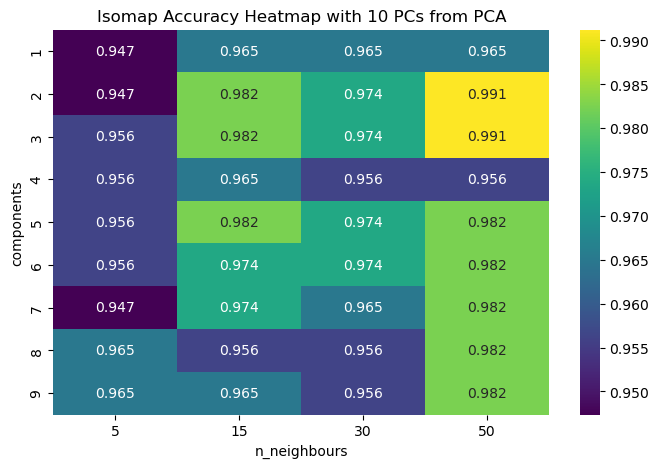

In [ ]:
start_time = time.time()
start_mem = get_memory_usage()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X_scaled)

best_acc = 0
best_components = None

accuracies = []
n_neighbours_list = [5, 15, 30, 50]

print("Running Isomap sweeps...\n")

for n in range(1, 10):  
    for p in n_neighbors_list:

        print(f"Testing: n_components={n}, n_neighbours={p} ...")

        isomap = Isomap(
            n_components=n,
            n_neighbors=p)

        X_isomap = isomap.fit_transform(X_pca)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_isomap, y_train.values.ravel(), test_size=0.2, random_state=42
        )

        # Train classifier
        clf = LogisticRegression(max_iter=1500)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracies.append((n, p, acc))

        print(f" -> Accuracy = {acc:.5f}")

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (n, p)


# Print best result
print("\n==============================")
print(f" Best Isomap parameters:")
print(f"   n_components = {best_params[0]}")
print(f"   n_neighbours = {best_params[1]}")
print(f" Best accuracy  = {best_acc:.5f}")
print("==============================")

end_time = time.time()
end_mem = get_memory_usage()

elapsed = end_time - start_time
mem_used = end_mem - start_mem

print(f"Isomap + PCA took: Time={elapsed:.2f}s, Memory={mem_used:.2f}MB")

df = pd.DataFrame(accuracies, columns=["components", "n_neighbours", "accuracy"])

pivot = df.pivot(index="components", columns="n_neighbours", values="accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Isomap Accuracy Heatmap with 10 PCs from PCA")
plt.show()

The best accuracy for each non-linear technique was achieved when running it on the regularly scaled dataset as well as 10 PC components from PCA. However, PCA can help filter out some initial noise and reduce the size of the initial dataset as TSNE and UMAP are computationally intensive. We can see from the results, applying PCA then the non-linear technique preserves the accuracy, and in most cases, it reduces the compuational time and memory usage.